<b>Research question:</b> Can pollutants information be used to predict the quality of the air for the next day in an specific area?

There is an index called Air Quality Index (AQI). This index is used to indicate the status of the air in an specific location or area, it can be good, moderate, unhealthy etc. The possible values are as follow:

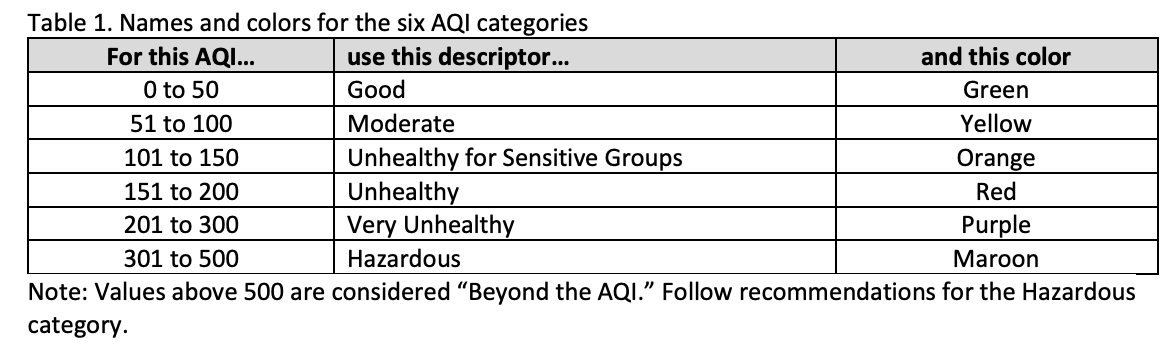

AQI can be calculated hourly, daily, monthly, anually, but the usual way is daily; for the purpose of this project, we will focus only on working with daily data, thus we will only calculate AQI daily.

To calculate the AQI, we need information from some pollutants: criteria gases (OZ, SO2, CO, NO2) and Particulates (PM2.5, PM10). We calculate a subindex by each pollutant per day, then AQI will be equal to the highest pollutant's subindex. To calculate the subindex of each pollutant, there is an equation. You can check the full procedure on how to calculate AQI in page 13 of the next file: https://www.airnow.gov/sites/default/files/2020-05/aqi-technical-assistance-document-sept2018.pdf. 

Info has been collected from: https://www.airnow.gov/sites/default/files/2020-05/aqi-technical-assistance-document-sept2018.pdf

We will focus on trying to predict the AQI for the next day in an specific city in the US (no city has been selected yet). The data we will be working with is in: https://aqs.epa.gov/aqsweb/airdata/download_files.html#Daily. There is a separate file for each pollutant, however we will be using the API and no the the csv files. We will also use the temperature and wind information in the modelling part. The api documentation is in: https://aqs.epa.gov/aqsweb/documents/data_api.html. We can use my credentials or you can create your own. <br>

Dictionary of the data: https://aqs.epa.gov/aqsweb/airdata/FileFormats.html#_daily_summary_files

To get the AQI for a day, we need the information from all the pollutants. Once we gather all the information, the AQI per day will be the highest AQI value calculated for each pollutant.

Some more documentation: https://aqs.epa.gov/aqsweb/airdata/FileFormats.html#_introduction

### IMPORTING LIBRARIES
Remember to "pip install [name_library]" every library that you don't have

In [1]:
import requests
import pandas as pd
import time
from functools import reduce
import glob

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## API CREDENTIALS
Like I said, if you want to use yours, just read the doc on how to create them, if not using mines is fine!

AirData API: https://aqs.epa.gov/aqsweb/documents/data_api.html <br>
API Variables: https://aqs.epa.gov/aqsweb/documents/data_api.html#variables <br>
API Services: https://aqs.epa.gov/aqsweb/documents/data_api.html#details <br>

In [88]:
email = 'jess.clix2@mail.dcu.ie'
key= 'dungazelle85'

### Checking if API is working

In [89]:
response = requests.get('https://aqs.epa.gov/data/api/metaData/isAvailable')
print(response.json())
print(response)

{'Header': [{'status': 'API service is up and running healthy. Status: connection_pool: size: 5, connections: 1, in use: 1, waiting_in_queue: 0', 'request_time': '2022-03-15T12:31:24-04:00', 'url': 'http://aqs.epa.gov/api/metaData/isAvailable'}], 'Data': []}
<Response [200]>


### Dictionary
I will create a variable with the dictionary to have it in hand.

In [191]:
dictionary = pd.read_csv("data/dictionary.csv",encoding = "ISO-8859-1")
# dictionary[dictionary['field_name'] == 'state_code']

## STATES CODE LIST
This an example on how to access the services of the api. I will print the first 10 items of the states list. 

In [26]:
params = {'email':email,
          'key': key
         }
response = requests.get(
    url='https://aqs.epa.gov/data/api/list/states',
    params=params
)

states = pd.json_normalize(response.json(),'Data')
print("This list has", states.shape[0], "states.")
display(states.head(10))
# states[states['value_represented'] == 'California']

This list has 56 states.


,code,value_represented
0,01,Alabama
1,02,Alaska
2,04,Arizona
3,05,Arkansas
4,06,California
5,08,Colorado
6,09,Connecticut
7,10,Delaware
8,11,District Of Columbia
9,12,Florida


<ul> 
    <li>We will be using all the states in the US </li>
    <li>Now that we are able to connect to the API, next step will be bringing the pollutant's info to calculate AQI</li>
 <li>To bring this info, we would need to make multiple calls, since there is an endpoint for every pollutant</li>
    <li> We first need to know the codes of the pollutants we are interested on </li>
</ul>

### Pollutants code List
With this list, we would be able to know the codes of the pollutants

In [91]:
params = {'email':'jess.clix2@mail.dcu.ie',
          'key': 'dungazelle85'
         }
response = requests.get(
    url='https://aqs.epa.gov/data/api/list/parametersByClass?&pc=CRITERIA',
    params=params
)

pollutants = pd.json_normalize(response.json(),'Data')
pollutants_code = ['44201','42401','42101','42602','88101','81102']
pollutants = pollutants.loc[(pollutants['code'].isin(pol_list))].reset_index()

pollutants

,index,code,value_represented
0,1,42101,Carbon monoxide
1,2,42401,Sulfur dioxide
2,3,42602,Nitrogen dioxide (NO2)
3,4,44201,Ozone
4,5,81102,PM10 Total 0-10um STP
5,7,88101,PM2.5 - Local Conditions


<b>We are interested in the following codes:</b> 44201, 42401, 42101, 42602, 88101, 81102. The codes for the temperature and wind information are not here, I will donwload manually those files.

# DATA COLLECTION

### OZONE (O3)

To limit the range of dates, we can use the API variables bdate and edate. <br>
<b>bdate standes for beginning date and edate for ending date</b>

In [45]:
# state = '06'
start_date = '20200101'
end_date = '20201231'

In [81]:
start_time = time.time()
print("Started at:",time.asctime( time.localtime(start_time) ) )

raw_data = pd.DataFrame([])

with requests.session() as session:
    for state in states.itertuples():
#         print("Getting info for:", state[2]) 
        params = {'email':email,
                  'key': key,
                  'state':state[1,
                  'bdate':start_date,
                  'edate':end_date,
                  'param':'44201'
                 }

        response = session.get(
            url='https://aqs.epa.gov/data/api/dailyData/byState',
            params=params
        )
           
        raw_data = pd.concat([raw_data, pd.json_normalize(response.json(),'Data')])

end_time = time.time()
print("--- %s seconds ---" % (end_time - start_time) )
print("Ended at:",time.asctime( time.localtime(end_time) ) )

Started at: Tue Mar 15 13:16:20 2022
--- 119.44207286834717 seconds ---
Ended at: Tue Mar 15 13:18:19 2022


In [86]:
raw_data.to_csv('data/raw_data/'+start_date[0:4]+'/ozone_test_'+start_date+'-'+end_date+'.csv', index=False)

### Sulfur Dioxide (SO2)

In [92]:
start_time = time.time()
print("Started at:",time.asctime( time.localtime(start_time) ) )

raw_data = pd.DataFrame([])

with requests.session() as session:
    for state in states.itertuples():
        print("Getting info for:", state[2]) 
        params = {'email':email,
                  'key': key,
                  'state':state[1],
                  'bdate':start_date,
                  'edate':end_date,
                  'param':'42401'
                 }

        response = session.get(
            url='https://aqs.epa.gov/data/api/dailyData/byState',
            params=params
        )
           
        raw_data = pd.concat([raw_data, pd.json_normalize(response.json(),'Data')])

end_time = time.time()
print("--- %s seconds ---" % (end_time - start_time) )
print("Ended at:",time.asctime( time.localtime(end_time) ) )

In [ ]:
raw_data.to_csv('data/raw_data/'+start_date[0:4]+'/sulfur_test_'+start_date+'-'+end_date+'.csv', index=False)

### Carbon Monoxide (CO)

In [81]:
start_time = time.time()
print("Started at:",time.asctime( time.localtime(start_time) ) )

raw_data = pd.DataFrame([])

with requests.session() as session:
    for state in states.itertuples():
#         print("Getting info for:", state[2]) 
        params = {'email':email,
                  'key': key,
                  'state':state[1],
                  'bdate':start_date,
                  'edate':end_date,
                  'param':'42101'
                 }

        response = session.get(
            url='https://aqs.epa.gov/data/api/dailyData/byState',
            params=params
        )
           
        raw_data = pd.concat([raw_data, pd.json_normalize(response.json(),'Data')])

end_time = time.time()
print("--- %s seconds ---" % (end_time - start_time) )
print("Ended at:",time.asctime( time.localtime(end_time) ) )

Started at: Tue Mar 15 13:16:20 2022
--- 119.44207286834717 seconds ---
Ended at: Tue Mar 15 13:18:19 2022


In [101]:
raw_data.to_csv('data/raw_data/'+start_date[0:4]+'/carbon_test_'+start_date+'-'+end_date+'.csv', index=False)

'data/raw_data/2020/carbon_test_20200101-20201231.csv'

### Nitrogen Dioxide (NO2)

In [81]:
start_time = time.time()
print("Started at:",time.asctime( time.localtime(start_time) ) )

raw_data = pd.DataFrame([])

with requests.session() as session:
    for state in states.itertuples():
#         print("Getting info for:", state[2]) 
        params = {'email':email,
                  'key': key,
                  'state':state[1],
                  'bdate':start_date,
                  'edate':end_date,
                  'param':'42602'
                 }

        response = session.get(
            url='https://aqs.epa.gov/data/api/dailyData/byState',
            params=params
        )
           
        raw_data = pd.concat([raw_data, pd.json_normalize(response.json(),'Data')])

end_time = time.time()
print("--- %s seconds ---" % (end_time - start_time) )
print("Ended at:",time.asctime( time.localtime(end_time) ) )

Started at: Tue Mar 15 13:16:20 2022
--- 119.44207286834717 seconds ---
Ended at: Tue Mar 15 13:18:19 2022


In [86]:
raw_data.to_csv('data/raw_data/'+start_date[0:4]+'/nitrogen_test_'+start_date+'-'+end_date+'.csv', index=False)

### PM 2.5

In [81]:
start_time = time.time()
print("Started at:",time.asctime( time.localtime(start_time) ) )

raw_data = pd.DataFrame([])

with requests.session() as session:
    for state in states.itertuples():
#         print("Getting info for:", state[2]) 
        params = {'email':email,
                  'key': key,
                  'state':state[1],
                  'bdate':start_date,
                  'edate':end_date,
                  'param':'88101'
                 }

        response = session.get(
            url='https://aqs.epa.gov/data/api/dailyData/byState',
            params=params
        )
           
        raw_data = pd.concat([raw_data, pd.json_normalize(response.json(),'Data')])

end_time = time.time()
print("--- %s seconds ---" % (end_time - start_time) )
print("Ended at:",time.asctime( time.localtime(end_time) ) )

Started at: Tue Mar 15 13:16:20 2022
--- 119.44207286834717 seconds ---
Ended at: Tue Mar 15 13:18:19 2022


In [86]:
raw_data.to_csv('data/raw_data/'+start_date[0:4]+'/pm25_test_'+start_date+'-'+end_date+'.csv', index=False)

### PM10

In [35]:
start_time = time.time()
print("Started at:",time.asctime( time.localtime(start_time) ) )

raw_data = pd.DataFrame([])

with requests.session() as session:
    for state in states.itertuples():
#         print("Getting info for:", state[2]) 
        params = {'email':email,
                  'key': key,
                  'state':state[1],
                  'bdate':start_date,
                  'edate':end_date,
                  'param':'81102'
                 }

        response = session.get(
            url='https://aqs.epa.gov/data/api/dailyData/byState',
            params=params
        )
           
        raw_data = pd.concat([raw_data, pd.json_normalize(response.json(),'Data')])

end_time = time.time()
print("--- %s seconds ---" % (end_time - start_time) )
print("Ended at:",time.asctime( time.localtime(end_time) ) )

In [86]:
raw_data.to_csv('data/raw_data/'+start_date[0:4]+'/pm10_test_'+start_date+'-'+end_date+'.csv', index=False)

# DATA INTEGRATION

I will read the information of each pollutant and meteroligical variable for the whole years

#### Ozone

In [9]:
path = "data/raw_data/"
files = glob.glob(path+"*/ozone*.csv")

data = []
for file in files:
    df = pd.read_csv(file, index_col=None, header = 0)
    data.append(df)

ozone = pd.concat(data, axis=0, ignore_index=True)
ozone_by_state = ozone[['State Code','Date Local','State Name','AQI']].groupby(['State Code','Date Local',\
                                     'State Name'])['AQI'].max().to_frame().reset_index()
ozone_by_state.rename(columns={'AQI': 'OZ_AQI', }, inplace=True)
# ozone = ozone[ozone['State Name'] == 'California'][['State Code','County Code','Site Num','Date Local','State Name','AQI']].reset_index(drop=True)
# ozone.rename(columns={'AQI': 'OZ_AQI', }, inplace=True)

#### Sulfur

In [10]:
path = "data/raw_data/"
files = glob.glob(path+"*/sulfur*.csv")

data = []
for file in files:
    df = pd.read_csv(file, index_col=None, header = 0)
    data.append(df)

sulfur = pd.concat(data, axis=0, ignore_index=True)
sulfur_by_state = sulfur[['State Code','Date Local','State Name','AQI']].groupby(['State Code','Date Local',\
                                     'State Name'])['AQI'].max().to_frame().reset_index()
sulfur_by_state.rename(columns={'AQI': 'SO_AQI', }, inplace=True)
# sulfur = sulfur[sulfur['State Name'] == 'California'][['State Code','County Code','Site Num','Date Local','State Name','AQI']].reset_index(drop=True)
# sulfur.rename(columns={'AQI': 'SO_AQI', }, inplace=True)

#### Carbon

In [11]:
path = "data/raw_data/"
files = glob.glob(path+"*/carbon*.csv")

data = []
for file in files:
    df = pd.read_csv(file, index_col=None, header = 0)
    data.append(df)

carbon = pd.concat(data, axis=0, ignore_index=True)
carbon_by_state = carbon[['State Code','Date Local','State Name','AQI']].groupby(['State Code','Date Local',\
                                     'State Name'])['AQI'].max().to_frame().reset_index()
carbon_by_state.rename(columns={'AQI': 'CO_AQI', }, inplace=True)
# carbon = carbon[carbon['State Name'] == 'California'][['State Code','County Code','Site Num','Date Local','State Name','AQI']].reset_index(drop=True)
# carbon.rename(columns={'AQI': 'CO_AQI', }, inplace=True)

#### Nitrogen

In [12]:
path = "data/raw_data/"
files = glob.glob(path+"*/nitrogen*.csv")

data = []
for file in files:
    df = pd.read_csv(file, index_col=None, header = 0)
    data.append(df)

nitrogen = pd.concat(data, axis=0, ignore_index=True)
nitrogen_by_state = nitrogen[['State Code','Date Local','State Name','AQI']].groupby(['State Code','Date Local',\
                                     'State Name'])['AQI'].max().to_frame().reset_index()
nitrogen_by_state.rename(columns={'AQI': 'NO_AQI', }, inplace=True)
# nitrogen = nitrogen[nitrogen['State Name'] == 'California'][['State Code','County Code','Site Num','Date Local','State Name','AQI']].reset_index(drop=True)
# nitrogen.rename(columns={'AQI': 'NO_AQI', }, inplace=True)

#### PM2.5

In [13]:
path = "data/raw_data/"
files = glob.glob(path+"*/pm2_5*.csv")

data = []
for file in files:
    df = pd.read_csv(file, index_col=None, header = 0)
    data.append(df)

pm25 = pd.concat(data, axis=0, ignore_index=True)
pm25_by_state = pm25[['State Code','Date Local','State Name','AQI']].groupby(['State Code','Date Local',\
                                     'State Name'])['AQI'].max().to_frame().reset_index()
pm25_by_state.rename(columns={'AQI': 'PM25_AQI', }, inplace=True)
# pm25 = pm25[pm25['State Name'] == 'California'][['State Code','County Code','Site Num','Date Local','State Name','AQI']].reset_index(drop=True)
# pm25.rename(columns={'AQI': 'PM25_AQI', }, inplace=True)

#### PM10

In [14]:
path = "data/raw_data/"
files = glob.glob(path+"*/pm10*.csv")

data = []
for file in files:
    df = pd.read_csv(file, index_col=None, header = 0)
    data.append(df)

pm10 = pd.concat(data, axis=0, ignore_index=True)
pm10_by_state = pm10[['State Code','Date Local','State Name','AQI']].groupby(['State Code','Date Local',\
                                     'State Name'])['AQI'].max().to_frame().reset_index()
pm10_by_state.rename(columns={'AQI': 'PM10_AQI', }, inplace=True)
# pm10 = pm10[pm10['State Name'] == 'California'][['State Code','County Code','Site Num','Date Local','State Name','AQI']].reset_index(drop=True)
# pm10.rename(columns={'AQI': 'PM10_AQI', }, inplace=True)

#### TEMP

In [15]:
path = "data/raw_data/"
files = glob.glob(path+"*/daily_TEMP*.csv")

data = []
for file in files:
    df = pd.read_csv(file, index_col=None, header = 0)
    data.append(df)

temp = pd.concat(data, axis=0, ignore_index=True)
temp_by_state = temp[['State Code','Date Local','State Name','Arithmetic Mean']].groupby(['State Code','Date Local',\
                                     'State Name'])['Arithmetic Mean'].mean().to_frame().reset_index()
temp_by_state.rename(columns={'Arithmetic Mean': 'Temp', }, inplace=True)

#### WIND

In [16]:
path = "data/raw_data/"
files = glob.glob(path+"*/daily_WIND*.csv")

data = []
for file in files:
    df = pd.read_csv(file, index_col=None, header = 0)
    data.append(df)

wind = pd.concat(data, axis=0, ignore_index=True)
# Wind Direction - Resultant    249602 values betweeen 0 and 360, compass.
# Wind Speed - Resultant        246693 wind speed in knots
wind_direction = wind[wind['Parameter Name'] == 'Wind Direction - Resultant']
wind_speed = wind[wind['Parameter Name'] == 'Wind Speed - Resultant']

wind_dir_by_state = wind_direction[['State Code','Date Local','State Name','Arithmetic Mean']].groupby(['State Code','Date Local',\
                                     'State Name'])['Arithmetic Mean'].mean().to_frame().reset_index()
wind_dir_by_state.rename(columns={'Arithmetic Mean': 'Wind Dir', }, inplace=True)

wind_speed_by_state = wind_speed[['State Code','Date Local','State Name','Arithmetic Mean']].groupby(['State Code','Date Local',\
                                     'State Name'])['Arithmetic Mean'].mean().to_frame().reset_index()
wind_speed_by_state.rename(columns={'Arithmetic Mean': 'Wind Speed', }, inplace=True)

### I will now create two dataframes, one df will have the pollutant information and the other one will have the metereological information

In [17]:
# pollutants_dfs = [ozone_by_state, sulfur_by_state, nitrogen_by_state, carbon_by_state, pm25_by_state, pm10_by_state]

# pollutants_info = reduce(lambda left,right: pd.merge(left,right, how='outer',\
#                                                     on=['State Code', 'State Name', 'Date Local']),pollutants_dfs)

# pollutants_info.rename(columns={'Date Local': 'Date', }, inplace=True)

In [18]:
# pollutants_dfs = [ozone, sulfur, nitrogen, carbon, pm25, pm10]

# pollutants_info = reduce(lambda left,right: pd.merge(left,right, how='outer',\
#                                                     on=['State Code', 'County Code','Site Num', 'State Name', 'Date Local']),pollutants_dfs)

# pollutants_info.rename(columns={'Date Local': 'Date', }, inplace=True)

In [19]:
# pollutants_info = ozone.merge(sulfur,how='inner',on=['State Code','County Code','State Name', 'Date Local'])\
# .merge(nitrogen,how='inner',on=['State Code', 'County Code','State Name', 'Date Local'])\
# .merge(carbon,how='inner',on=['State Code','County Code', 'State Name', 'Date Local'])\
# .merge(pm25,how='inner',on=['State Code', 'County Code','State Name', 'Date Local'])\
# .merge(pm10,how='inner',on=['State Code','County Code', 'State Name', 'Date Local'])

# pollutants_info.rename(columns={'Date Local': 'Date', }, inplace=True)
# pollutants_info.isnull().sum()

In [20]:
pollutants_info = ozone_by_state.merge(sulfur_by_state,how='outer',on=['State Code', 'State Name', 'Date Local'])\
.merge(nitrogen_by_state,how='outer',on=['State Code', 'State Name', 'Date Local'])\
.merge(carbon_by_state,how='outer',on=['State Code', 'State Name', 'Date Local'])\
.merge(pm25_by_state,how='outer',on=['State Code', 'State Name', 'Date Local'])\
.merge(pm10_by_state,how='outer',on=['State Code', 'State Name', 'Date Local'])

pollutants_info.rename(columns={'Date Local': 'Date', }, inplace=True)
pollutants_info.isnull().sum()

State Code        0
Date              0
State Name        0
OZ_AQI         1336
SO_AQI         2814
NO_AQI         7858
CO_AQI         3014
PM25_AQI       3417
PM10_AQI      17195
dtype: int64

In [21]:
metereoligcal_info =reduce(lambda left,right: pd.merge(left,right, how='outer',\
                                                       on=['State Code', 'State Name', 'Date Local']),\
                           [temp_by_state, wind_dir_by_state, wind_speed_by_state])

metereoligcal_info.rename(columns={'Date Local': 'Date', }, inplace=True)

### The target variable which we are going to try to predict is the AQI category.
For this variable, we are going to use the files corresponding to the years of: 2015-2020.
Link to download them: https://aqs.epa.gov/aqsweb/airdata/download_files.html#AQI

In [22]:
path = "data/raw_data/"
files = glob.glob(path+"*/daily_aqi*.csv")

data = []
for file in files:
    df = pd.read_csv(file, index_col=None, header = 0)
    data.append(df)

daily_aqi = pd.concat(data, axis=0, ignore_index=True)

daily_aqi['Sum sites reporting'] = daily_aqi.groupby(['State Name','State Code',\
                                                      'Date'])['Number of Sites Reporting'].transform("sum")
aqi_by_states = daily_aqi[daily_aqi['AQI'] == \
                          daily_aqi.groupby(['State Name','State Code','Date'])['AQI'].transform(max)]\
                        [['State Name','State Code','Date','Sum sites reporting','AQI','Category']]

aqi_by_states = aqi_by_states.drop_duplicates(keep='first')

## Joining pollutants information and metereolical information with AQI daily values to have the final dataset

In [29]:
final_data = pd.merge(aqi_by_states, \
              pollutants_info[['State Code', 'Date','OZ_AQI', 'SO_AQI', 'NO_AQI',\
                              'CO_AQI', 'PM25_AQI', 'PM10_AQI']],\
              how='inner',\
              left_on=['State Code','Date'],\
              right_on=['State Code','Date']             
             )

final_data = pd.merge(final_data, \
              metereoligcal_info[['State Code', 'Date','Temp', 'Wind Dir','Wind Speed']],\
              how='inner',\
              left_on=['State Code','Date'],\
              right_on=['State Code','Date']             
             )

In [30]:
final_data['Date'] = pd.to_datetime(final_data['Date'])
final_data['Year'] = final_data['Date'].dt.year
final_data['Month'] = final_data['Date'].dt.month
final_data['Day'] = final_data['Date'].dt.day

final_data.head()

,State Name,State Code,Date,Sum sites reporting,AQI,Category,OZ_AQI,SO_AQI,NO_AQI,CO_AQI,PM25_AQI,PM10_AQI,Temp,Wind Dir,Wind Speed,Year,Month,Day
0,Alabama,1,2017-04-23,28,33,Good,33.0,33.0,4.0,3.0,10.0,13.0,60.043055,255.861111,4.825000,2017,4,23
1,Alabama,1,2017-04-25,38,74,Moderate,74.0,56.0,22.0,7.0,35.0,19.0,67.054167,177.388889,2.137500,2017,4,25
2,Alabama,1,2017-05-01,38,67,Moderate,67.0,51.0,11.0,5.0,23.0,15.0,67.559722,224.250000,4.462500,2017,5,1
3,Alabama,1,2017-05-04,36,47,Good,46.0,43.0,12.0,5.0,30.0,10.0,61.244444,194.722222,5.484722,2017,5,4
4,Alabama,1,2017-05-05,29,47,Good,47.0,47.0,18.0,5.0,10.0,10.0,52.045833,243.125000,4.652778,2017,5,5


In [31]:
final_data.columns

Index(['State Name', 'State Code', 'Date', 'Sum sites reporting', 'AQI',
       'Category', 'OZ_AQI', 'SO_AQI', 'NO_AQI', 'CO_AQI', 'PM25_AQI',
       'PM10_AQI', 'Temp', 'Wind Dir', 'Wind Speed', 'Year', 'Month', 'Day'],
      dtype='object')

In [32]:
final_data[(final_data['OZ_AQI'].isnull())\
          &(final_data['SO_AQI'].isnull())\
          &(final_data['NO_AQI'].isnull())\
          &(final_data['CO_AQI'].isnull())\
          &(final_data['PM25_AQI'].isnull())\
          &(final_data['PM10_AQI'].isnull())].value_counts()

final_data[['OZ_AQI', 'SO_AQI', 'NO_AQI', 'CO_AQI', 'PM25_AQI','PM10_AQI']].isnull().value_counts()

OZ_AQI  SO_AQI  NO_AQI  CO_AQI  PM25_AQI  PM10_AQI
False   False   False   False   False     False       70952
                                          True        13371
                True    False   False     False        4659
                False   False   True      False         897
                        True    False     False         585
                        False   True      True          570
        True    False   False   False     False         453
True    True    True    True    False     True          431
False   False   True    False   True      False         349
        True    True    True    False     True          266
        False   True    False   False     True          141
                False   True    False     True           90
True    True    True    True    False     False          68
False   True    True    True    False     False          51
        False   False   True    True      False          42
                True    True    False     False  

In [33]:
final_data.drop(final_data[(final_data['NO_AQI'].isnull())\
                          &(final_data['CO_AQI'].isnull())].index, inplace=True)

final_data.drop(final_data[(final_data['PM25_AQI'].isnull())\
                          &(final_data['NO_AQI'].isnull())].index, inplace=True)

final_data.drop(final_data[(final_data['PM25_AQI'].isnull())\
                          &(final_data['OZ_AQI'].isnull())].index, inplace=True)

In [34]:
final_data.shape

(91851, 18)

In [36]:
# final_data.to_csv('data/aqi_data.csv', index=False)
# final_data.head()

,State Name,State Code,Date,Sum sites reporting,AQI,Category,OZ_AQI,SO_AQI,NO_AQI,CO_AQI,PM25_AQI,PM10_AQI,Temp,Wind Dir,Wind Speed,Year,Month,Day
0,Alabama,1,2017-04-23,28,33,Good,33.0,33.0,4.0,3.0,10.0,13.0,60.043055,255.861111,4.825000,2017,4,23
1,Alabama,1,2017-04-25,38,74,Moderate,74.0,56.0,22.0,7.0,35.0,19.0,67.054167,177.388889,2.137500,2017,4,25
2,Alabama,1,2017-05-01,38,67,Moderate,67.0,51.0,11.0,5.0,23.0,15.0,67.559722,224.250000,4.462500,2017,5,1
3,Alabama,1,2017-05-04,36,47,Good,46.0,43.0,12.0,5.0,30.0,10.0,61.244444,194.722222,5.484722,2017,5,4
4,Alabama,1,2017-05-05,29,47,Good,47.0,47.0,18.0,5.0,10.0,10.0,52.045833,243.125000,4.652778,2017,5,5


In [36]:
final_data = final_data[final_data['State Name'] == 'California'].reset_index(drop=True)
final_data.to_csv('data/aqi_data.csv', index=False)
final_data.head()

,State Name,State Code,Date,Sum sites reporting,AQI,Category,OZ_AQI,SO_AQI,NO_AQI,CO_AQI,PM25_AQI,PM10_AQI,Temp,Wind Dir,Wind Speed,Year,Month,Day
0,California,6,2015-02-11,243,144,Unhealthy for Sensitive Groups,47.0,7.0,55.0,23.0,85.0,44.0,59.718169,161.101766,3.603771,2015,2,11
1,California,6,2015-02-23,244,102,Unhealthy for Sensitive Groups,46.0,3.0,42.0,10.0,63.0,72.0,49.906393,184.524022,4.683368,2015,2,23
2,California,6,2015-03-13,244,129,Unhealthy for Sensitive Groups,80.0,16.0,61.0,27.0,71.0,48.0,67.117052,160.797726,3.640592,2015,3,13
3,California,6,2015-03-25,242,112,Unhealthy for Sensitive Groups,93.0,11.0,55.0,11.0,111.0,58.0,64.194019,201.753063,4.319063,2015,3,25
4,California,6,2015-04-24,256,142,Unhealthy for Sensitive Groups,64.0,4.0,42.0,8.0,66.0,107.0,58.213829,230.426796,5.462903,2015,4,24
